In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from scipy.sparse.linalg import svds

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
from src.models import (load_data
                        , data_summary
                        , combine_tables
                        , collab_mat
                        , svd_mat
                        , svd_model
                        , surprise_bench
                        , top_biz_pred
                        , NMF_Mat
                        , NN_Model
                        , NN_Results_df
                        , con_bas_biz_rec
                       )

### Load Data

In [11]:
biz_df, rev_df, ckin_df, pho_df, tip_df, user_df = load_data()

In [12]:
data_summary(biz_df
             , rev_df
             , ckin_df
             , pho_df
             , tip_df
             , user_df)

name,rows,colums
business,192609,14
review,6685900,9
checkin,161950,2
photo,200000,4
tip,1223094,5
user,1637138,22


In [13]:
user_rev_biz = combine_tables(user_df
                              , rev_df
                              , biz_df)

In [25]:
user_rev_biz.city.value_counts()[0:5]

Las Vegas     1757375
Phoenix        645716
Toronto        434349
Scottsdale     329826
Charlotte      273989
Name: city, dtype: int64

In [15]:
user_biz_collab_mat = collab_mat('Scottsdale'
                                 , user_rev_biz)

In [16]:
user_biz_collab_mat.shape

(140940, 7081)

### SVD

In [20]:
sigma, user_biz_predictions = svd_mat(user_biz_collab_mat, k=40)

### Precictions

In [21]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = user_biz_predictions
             , n=5)

('Kristin',
 ['True Food Kitchen',
  'Cafe Monarch',
  'The Herb Box',
  'Sweet Republic',
  'Talking Stick Resort'])

In [22]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:5]

3360      Butters Pancakes & Café
312378                 Wildflower
600627               Flower Child
624904               Viet Kitchen
744479                 Wildflower
Name: biz_name, dtype: object

### Validation

In [88]:
from surprise import (SVD
                      , SVDpp
                      , SlopeOne
                      , NMF
                      , NormalPredictor
                      , KNNBaseline
                      , KNNBasic
                      , KNNWithMeans
                      , KNNWithZScore
                      , BaselineOnly
                      , CoClustering)
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection.validation import cross_validate
from surprise import accuracy

In [101]:
data, svd_acc, svd_cv = svd_model(df = user_rev_biz)

RMSE: 0.7039


In [30]:
svd_acc

0.7025753593716568

In [31]:
svd_cv

array([0.69526682, 0.70389056, 0.70047807, 0.69866807, 0.70012946])

In [104]:
# bench_df = surprise_bench(dat = data) # import from models.py doesn't work!

In [ ]:
bench_df = svd_model(dat=data)

In [90]:
def surprise_bench(dat):
    """
    Creates benchmark dataframe of SVD, NMF, NormalPredictor, and Baseline with 
    5 Fold cross validation and returns rmse metrics
    """

    benchmark = []
    
    # Iterate over all algorithms
    for algorithm in [SVD()
                      , NMF()
                      , NormalPredictor()
                      , BaselineOnly()
                     ]:
    # Perform cross validation
        results = cross_validate(algorithm
                                 , dat
                                 , measures=['RMSE']
                                 , cv=5
                                 , verbose = False
                                )

        # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)

    return pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')


In [91]:
surprise_bench(data)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
NMF,0.641081,25.243075,0.435877
SVD,0.699325,15.144834,0.526336
BaselineOnly,0.718332,2.363852,0.563503
NormalPredictor,1.102319,0.664421,0.524076


### NMF

In [92]:
NMF_results = cross_validate(NMF(), data, cv = 5)

In [93]:
NMF_results['test_rmse']

array([0.63889333, 0.63572869, 0.63549771, 0.63658695, 0.64606266])

In [94]:
from sklearn.decomposition import NMF

In [98]:
nmf_mat = NMF_Mat(user_biz_collab_mat)

In [99]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = nmf_mat
             , n=5)

('Kristin',
 ['True Food Kitchen',
  'North Italia',
  "Portillo's Hot Dogs",
  "Mastro's Ocean Club",
  'Sweet Republic'])

In [100]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:10]

3360        Butters Pancakes & Café
312378                   Wildflower
600627                 Flower Child
624904                 Viet Kitchen
744479                   Wildflower
746301     Original Breakfast House
771054      Andreoli Italian Grocer
838710                 Barrio Queen
1147492        Rocket Burger & Subs
1155989                 Rustic Cafe
Name: biz_name, dtype: object

### Neural Network Recommender



In [38]:
# https://www.youtube.com/watch?v=4vwNkHFuZBk

In [55]:
from tensorflow.keras.layers import (Input
                                     , Embedding
                                     , Dot
                                     , Flatten
                                    )
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import Callback

import os

In [127]:
X_test, model, history = NN_Model(df = user_rev_biz
                                 , n_factors = 5
                                 , ep = 21)


Testing loss: 14.817582237519101, acc: 0.0


Testing loss: 11.637468117049675, acc: 0.00018191299750469625


Testing loss: 9.490416378059315, acc: 0.0006185041856952012


Testing loss: 8.176243728471057, acc: 0.0012248808052390814


Testing loss: 7.350477243424827, acc: 0.001467431546188891


Testing loss: 6.818755949124871, acc: 0.0015401967102661729


Testing loss: 6.463896464556681, acc: 0.0015765792923048139


Testing loss: 6.22313673256807, acc: 0.0016735995886847377


Testing loss: 6.063839602696219, acc: 0.0017221097368746996


Testing loss: 5.955323530856598, acc: 0.0017706198850646615


Testing loss: 5.883285442004028, acc: 0.0017584923189133406


Testing loss: 5.830361452505958, acc: 0.0017706198850646615


Testing loss: 5.793323190744533, acc: 0.0017342371866106987


Testing loss: 5.765119042460099, acc: 0.0017948749009519815


Testing loss: 5.744207977848133, acc: 0.0017221097368746996


Testing loss: 5.72784064433304, acc: 0.0017706198850646615


Testing loss: 5.714797524

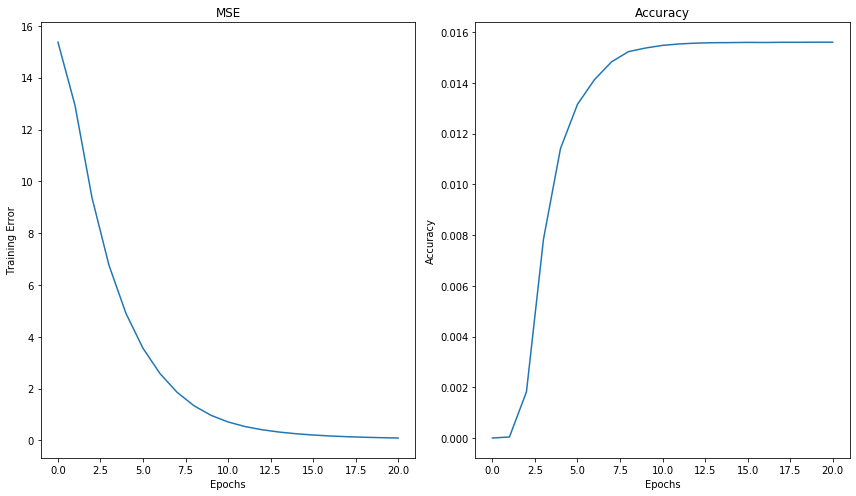

In [128]:
fig, ax = plt.subplots(1, 2, figsize=(12,7), tight_layout=True)
ax[0].plot(history.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Error')
ax[0].set_title('MSE')
    
ax[1].plot(history.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy');

In [134]:
NN_Results_df(mod = model
             , xtest = X_test
             , n=15)

,user_name,biz_name,average_stars,Prediction
1600473,Mirco,Merci French Cafe & Patisserie,4.81,4.744405
773319,Scott,McCormick-Stillman Railroad Park,3.62,3.585842
2675092,Ashley,Zoes Kitchen,4.11,4.332685
3141992,Dawn,Scottsdale Nails,4.70,4.473654
2063207,Shaila,Saints & Scissors Salon,4.71,0.156180
3693030,Shaya,Persian Room,4.06,3.987998
6037906,Marnie,Sir Grout Phoenix,3.75,-0.129827
1878741,Chelsea,Houston's Restaurant,4.25,4.457550
4351605,Horace,Nekter Juice Bar,4.75,4.916984
4458509,Stephanie,Blue Adobe Santa Fe Grille,3.75,3.724029


### Using Texts to Model Business to Business Similarity

In [136]:
con_bas_biz_rec(df = user_rev_biz, n = 5)

,name,rating
0,"Ferguson Bath, Kitchen & Lighting Gallery",0.516044
1,Scottsdale Rooter Plumbers,0.423362
2,Troon North Custom Tailor,0.421407
3,The Flower Cart,0.419961
4,Gainey Fabricare Cleaners,0.418511
